In [1]:
import os
import glob
import pickle
import math

import pandas as pd
import numpy as np
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import tqdm
from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.transform import df2regulons

import operator as op
from cytoolz import compose
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell
from pyscenic.plotting import plot_binarization, plot_rss

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor='white', fontsize = 12)

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.11.4 pandas==1.5.2 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.10.3 louvain==0.8.0 pynndescent==0.5.8


In [3]:
eec = pd.read_csv("./EEC_results/RSS_patients.csv", index_col= 0)
print(eec.shape)
eec.head()

(3, 196)


,AHR,AR,ARID3A,ARNT,ATF1,ATF3,ATF4,ATF7,BATF,BPTF,...,ZNF548,ZNF559,ZNF567,ZNF580,ZNF670,ZNF683,ZNF704,ZNF823,ZNF91,ZSCAN31
EEC-1,0.353251,0.245303,0.350845,0.251673,0.322317,0.319104,0.410665,0.239259,0.244426,0.320138,...,0.313437,0.334145,0.306436,0.322967,0.291678,0.328206,0.271742,0.279415,0.344435,0.287157
EEC-2,0.488241,0.256159,0.505438,0.435303,0.600685,0.550302,0.516380,0.441549,0.362525,0.596414,...,0.410046,0.569333,0.500158,0.583970,0.471458,0.264044,0.632629,0.370680,0.569069,0.550631
EEC-3,0.433968,0.274357,0.359039,0.265666,0.337683,0.394823,0.346412,0.278240,0.384761,0.321610,...,0.294932,0.324219,0.394821,0.375875,0.331910,0.282429,0.310547,0.382433,0.326221,0.242254


In [4]:
ov = pd.read_csv("./OV_results/RSS_patients.csv", index_col= 0)
ov.index = ["HGSOC-1", "HGSOC-2"]
print(ov.shape)
ov.head()

(2, 189)


,ARNT,ATF1,ATF3,ATF4,ATF6B,BACH1,BATF3,CEBPB,CEBPD,CEBPG,...,ZNF75A,ZNF76,ZNF770,ZNF773,ZNF799,ZNF808,ZSCAN20,ZSCAN9,ZXDA,ZXDB
HGSOC-1,0.427177,0.545063,0.431905,0.564329,0.450781,0.344628,0.693290,0.457455,0.446073,0.629064,...,0.200169,0.595907,0.426177,0.450708,0.558765,0.464621,0.279951,0.276543,0.382585,0.409561
HGSOC-2,0.399713,0.487987,0.567069,0.483693,0.553045,0.305141,0.362862,0.592200,0.610515,0.423570,...,0.260343,0.344875,0.611536,0.439033,0.436251,0.575449,0.229872,0.322160,0.387226,0.387245


In [5]:
cc = pd.read_csv("./CESC_results/RSS_patients.csv", index_col= 0)
cc.index = ["CC-1", "CC-2"]
print(cc.shape)
cc.head()

(2, 141)


,ARID5A,ARNT,ATF1,ATF2,ATF3,ATF6,BACH1,CEBPB,CEBPD,CLOCK,...,ZNF320,ZNF441,ZNF518A,ZNF675,ZNF701,ZNF704,ZNF721,ZNF726,ZNF85,ZNF891
CC-1,0.477613,0.482525,0.481527,0.478622,0.498841,0.485706,0.506830,0.584164,0.583760,0.518645,...,0.444802,0.349367,0.540969,0.476590,0.296709,0.516419,0.509551,0.441051,0.377855,0.428303
CC-2,0.497563,0.571785,0.568373,0.520261,0.520128,0.544176,0.539437,0.336173,0.448277,0.507872,...,0.607242,0.428166,0.518249,0.541953,0.275059,0.535980,0.512211,0.565993,0.496793,0.530618


In [6]:
tnbc = pd.read_csv("./BRCA_TNBC_results/RSS_patients.csv", index_col= 0)
print(tnbc.shape)
tnbc.head()

(5, 173)


,ASCL1,ATF1,ATF3,ATF4,ATF6,ATF7,BHLHE40,BPTF,CEBPA,CEBPB,...,ZNF384,ZNF486,ZNF490,ZNF518A,ZNF567,ZNF580,ZNF655,ZNF783,ZNF85,ZSCAN1
TNBC-1,0.236804,0.340683,0.248548,0.303573,0.283717,0.256304,0.249350,0.253438,0.283876,0.281799,...,0.339270,0.249960,0.304412,0.261310,0.244545,0.281800,0.237276,0.210685,0.234301,0.196635
TNBC-2,0.430710,0.381913,0.578194,0.431260,0.440730,0.430156,0.511867,0.420258,0.571756,0.412505,...,0.337400,0.435936,0.510842,0.533014,0.269880,0.596012,0.346202,0.409531,0.362012,0.509064
TNBC-3,0.229685,0.262366,0.280211,0.268059,0.270334,0.247588,0.270276,0.210544,0.226927,0.265413,...,0.281369,0.220086,0.244902,0.238217,0.222670,0.271915,0.235365,0.221627,0.264837,0.229298
TNBC-4,0.300740,0.345634,0.304514,0.415718,0.377719,0.310965,0.325994,0.326254,0.286705,0.359691,...,0.252521,0.266664,0.279274,0.353260,0.285713,0.283503,0.455102,0.232533,0.207014,0.320417
TNBC-5,0.249076,0.366468,0.263810,0.302618,0.338744,0.332993,0.324641,0.217732,0.234792,0.405088,...,0.213574,0.231892,0.242914,0.266616,0.248246,0.256733,0.297135,0.192788,0.223673,0.208408


In [7]:
er = pd.read_csv("./BRCA_ER_results/RSS_patients.csv", index_col= 0)
print(er.shape)
er.head()

(4, 158)


,ARNT,ARNTL,ATF1,ATF3,ATF4,BACH1,BATF,CEBPZ,CENPB,CLOCK,...,ZNF471,ZNF493,ZNF518A,ZNF548,ZNF580,ZNF672,ZNF682,ZNF704,ZNF729,ZNF76
ER-3,0.277019,0.306537,0.340462,0.349801,0.304374,0.259544,0.234833,0.285634,0.258948,0.247787,...,0.254174,0.200763,0.341669,0.313406,0.327511,0.328628,0.254877,0.269546,0.219456,0.252306
ER-4,0.255825,0.348833,0.360754,0.319954,0.453518,0.297964,0.308834,0.456267,0.247504,0.279577,...,0.199720,0.192253,0.388281,0.301319,0.328518,0.336294,0.240148,0.347194,0.293920,0.310230
ER-1,0.355856,0.274542,0.349645,0.368637,0.334306,0.385207,0.292021,0.325515,0.320522,0.344222,...,0.337144,0.226748,0.382977,0.322646,0.371856,0.363971,0.349771,0.341211,0.232291,0.335013
ER-2,0.428169,0.392896,0.419086,0.475313,0.420711,0.507037,0.493807,0.438897,0.386359,0.479883,...,0.346432,0.216296,0.375381,0.391992,0.491740,0.468878,0.483639,0.528321,0.292781,0.465960


In [8]:
def plot_rss(rss, cell_type, top_n=10, max_n=None, ax=None, pos = 30):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    if max_n is None:
        max_n = rss.shape[1]
    data = rss.T[cell_type].sort_values(ascending=False)[0:max_n]
    ax.plot(np.arange(len(data)), data, ".")
    ax.set_ylim([math.floor(data.min() * 100.0) / 100.0, math.ceil(data.max() * 100.0) / 100.0])
    ax.set_ylabel("RSS")
    ax.set_xlabel("Regulon")
    ax.set_title(cell_type)
    ax.set_xticklabels([])

    font = {
        "color": "red",
        "weight": "normal",
        "size": 12,
    }

    for idx, (regulon_name, rss_val) in enumerate(
        zip(data[0:top_n].index, data[0:top_n].values)
    ):
        #print(regulon_name, idx)
        ax.plot([idx, idx], [rss_val, rss_val], "r.")
        ax.text(
            idx + (max_n / 15) + ((idx/pos)*500),
            rss_val - idx/pos ,
            regulon_name,
            fontdict=font,
            horizontalalignment="left",
            verticalalignment="top",
        )
        previous_rss = rss_val
        
    
    return

In [18]:
FIGURES_FOLDERNAME = "./"
def savesvg(fname: str, fig, folder: str=FIGURES_FOLDERNAME) -> None:
    """
    Save figure as vector-based SVG image format.
    """
    fig.tight_layout()
    fig.savefig(os.path.join(folder, fname), format='png', dpi=300)

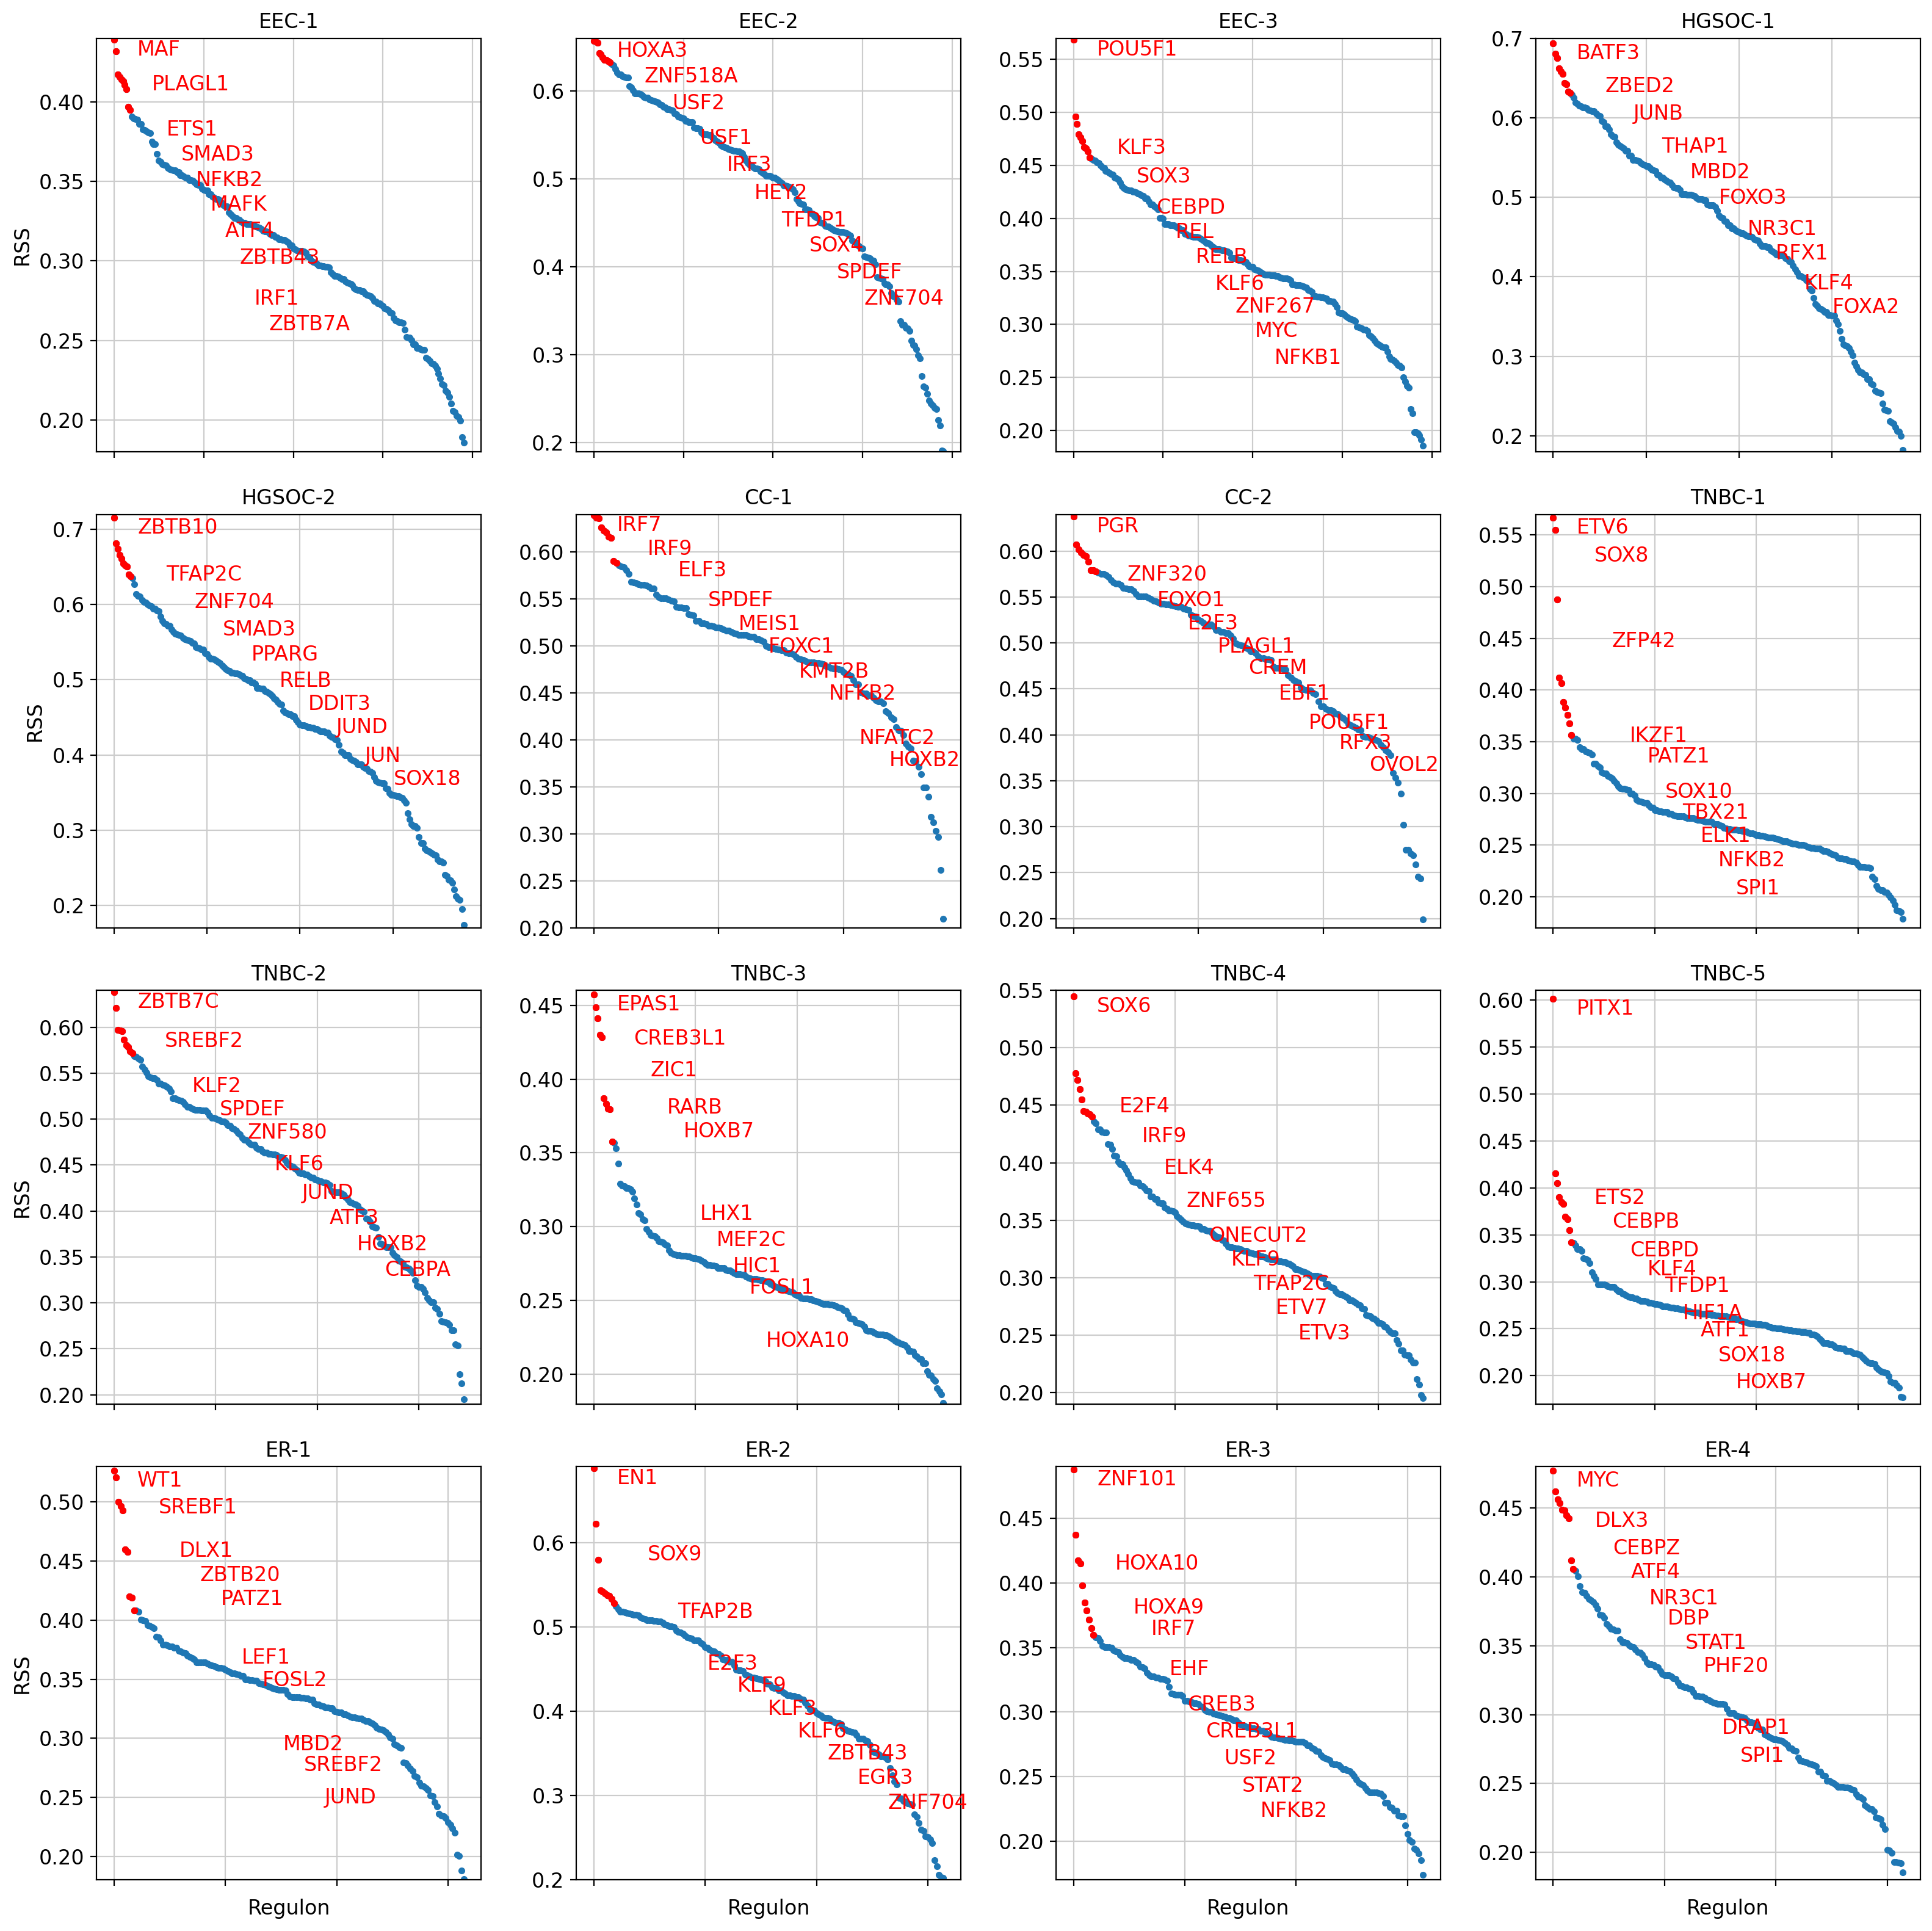

In [19]:
# sns.set()
# sns.set(style='whitegrid', font_scale=0.8)
fig, ((ax1, ax2, ax3, ax4), 
      (ax5, ax6, ax7, ax8), 
      (ax9, ax10, ax11, ax12), 
      (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, figsize=(16, 16), dpi=100)

plot_rss(eec, 'EEC-1', ax=ax1, pos = 70)
ax1.set_xlabel('')

plot_rss(eec, 'EEC-2', ax=ax2, pos = 35)
ax2.set_xlabel('')
ax2.set_ylabel('')

plot_rss(eec, 'EEC-3', ax=ax3, pos = 50)
ax3.set_xlabel('')
ax3.set_ylabel('')

plot_rss(ov, 'HGSOC-1', ax=ax4, pos = 35)
ax4.set_xlabel('')
ax4.set_ylabel('')

plot_rss(ov, 'HGSOC-2', ax=ax5, pos = 35)
ax5.set_xlabel('')

plot_rss(cc, 'CC-1', ax=ax6, pos = 45)
ax6.set_xlabel('')
ax6.set_ylabel('')

plot_rss(cc, 'CC-2', ax=ax7, pos = 45)
ax7.set_xlabel('')
ax7.set_ylabel('')

plot_rss(tnbc, 'TNBC-1', ax=ax8, pos = 65)
ax8.set_xlabel('')
ax8.set_ylabel('')

plot_rss(tnbc, 'TNBC-2', ax=ax9, pos = 40)
ax9.set_xlabel('')

plot_rss(tnbc, 'TNBC-3', ax=ax10, pos = 70)
ax10.set_xlabel('')
ax10.set_ylabel('')

plot_rss(tnbc, 'TNBC-4', ax=ax11, pos = 50)
ax11.set_xlabel('')
ax11.set_ylabel('')

plot_rss(tnbc, 'TNBC-5', ax=ax12, pos = 65)
ax12.set_xlabel('')
ax12.set_ylabel('')

plot_rss(er, 'ER-1', ax=ax13, pos = 60)

plot_rss(er, 'ER-2', ax=ax14, pos = 40)
ax14.set_ylabel('')


plot_rss(er, 'ER-3', ax=ax15, pos = 70)
ax15.set_ylabel('')

plot_rss(er, 'ER-4', ax=ax16, pos = 70)
ax16.set_ylabel('')
#savesvg('./patient-RSS-top10_regulons.png', fig)